<a href="https://colab.research.google.com/github/LilKedin/Inflation_Model/blob/main/Inflation%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARMA(1, 1) - CPI Inflation

This notebook contains the example code from "State Space Estimation of Time Series Models in Python: Statsmodels" for the ARMA(1, 1) model of CPI inflation.

In [43]:
# These are the basic import statements to get the required Python functionality
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data

For this example, we consider modeling quarterly CPI inflation. Below, we retrieve the data directly from the [Federal Reserve Economic Database](https://fred.stlouisfed.org/) using the `pandas_datareader` package.

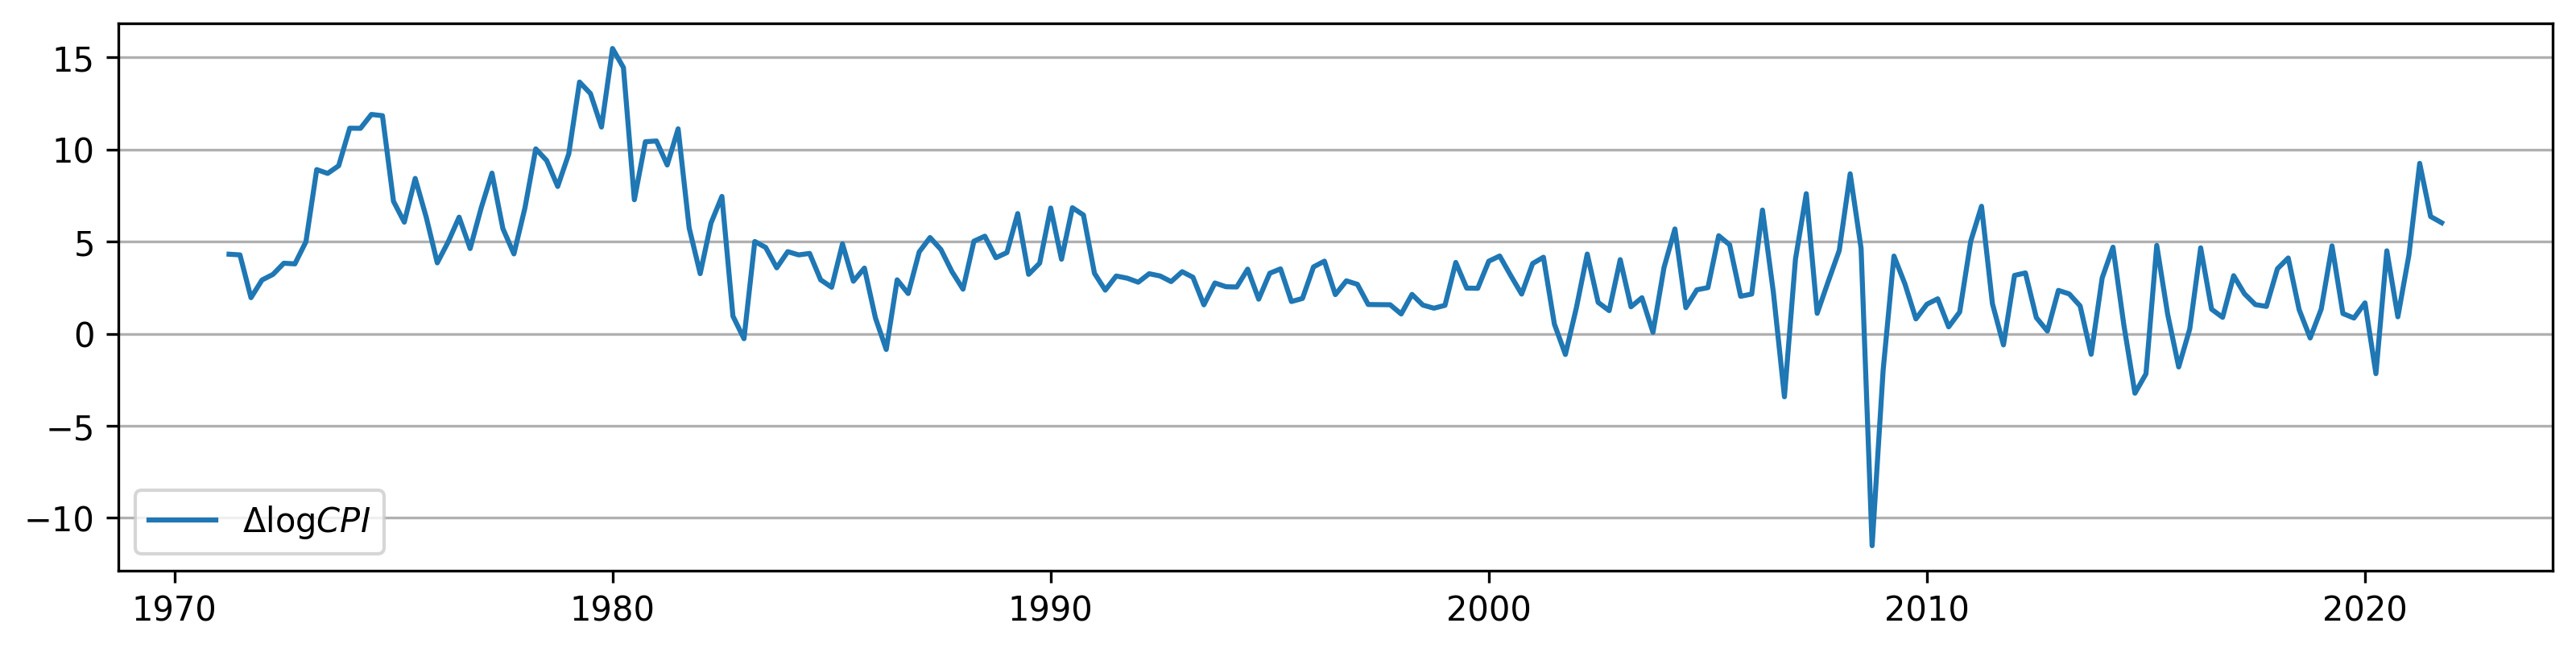

In [44]:
# Get the data from FRED
from pandas_datareader.data import DataReader
cpi = DataReader('CPIAUCNS', 'fred', start='1971-01', end='2021-12')
cpi.index = pd.DatetimeIndex(cpi.index, freq='MS')
inf = np.log(cpi).resample('QS').mean().diff()[1:] * 400

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(inf.index, inf, label=r'$\Delta \log CPI$')
ax.legend(loc='lower left')
ax.yaxis.grid();

## State space model

The ARMA(1, 1) model is:

$$
y_t = \phi y_{t-1} + \varepsilon_t + \theta_1 \varepsilon_{t-1}, \qquad \varepsilon_t \sim N(0, \sigma^2)
$$

and it can be written in state-space form as:

$$
\begin{align}
y_t & = \underbrace{\begin{bmatrix} 1 & \theta_1 \end{bmatrix}}_{Z} \underbrace{\begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix}}_{\alpha_t} \\
    \begin{bmatrix} \alpha_{1,t+1} \\ \alpha_{2,t+1} \end{bmatrix} & = \underbrace{\begin{bmatrix}
        \phi & 0 \\
        1      & 0     \\
    \end{bmatrix}}_{T} \begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix} +
    \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{R} \underbrace{\varepsilon_{t+1}}_{\eta_t} \\
\end{align}
$$

Below we construct a custom class, `ARMA11`, to estimate the ARMA(1, 1) model.

In [45]:
from statsmodels.tsa.statespace.tools import (constrain_stationary_univariate,
                                              unconstrain_stationary_univariate)

class ARMA11(sm.tsa.statespace.MLEModel):
    start_params = [0, 0, 1]
    param_names = ['phi', 'theta', 'sigma2']

    def __init__(self, endog):
        super(ARMA11, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')

        self['design', 0, 0] = 1.
        self['transition', 1, 0] = 1.
        self['selection', 0, 0] = 1.

    def transform_params(self, params):
        phi = constrain_stationary_univariate(params[0:1])
        theta = constrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**2
        return np.r_[phi, theta, sigma2]

    def untransform_params(self, params):
        phi = unconstrain_stationary_univariate(params[0:1])
        theta = unconstrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**0.5
        return np.r_[phi, theta, sigma2]

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(ARMA11, self).update(params, **kwargs)

        self['design', 0, 1] = params[1]
        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[2]

## Maximum likelihood estimation

With this class, we can instantiate a new object with the inflation data and fit the model by maximum likelihood methods.

In [46]:
inf_model = ARMA11(inf)
inf_results = inf_model.fit()

print(inf_results.summary())

                           Statespace Model Results                           
Dep. Variable:               CPIAUCNS   No. Observations:                  203
Model:                         ARMA11   Log Likelihood                -479.181
Date:                Sat, 14 May 2022   AIC                            964.361
Time:                        16:08:55   BIC                            974.301
Sample:                    04-01-1971   HQIC                           968.382
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.9796      0.015     63.261      0.000       0.949       1.010
theta         -0.6274      0.058    -10.907      0.000      -0.740      -0.515
sigma2         6.5158      0.329     19.787      0.0

Notice that the diagnostic tests reported in the lower table suggest that our residuals do not appear to be white noise - in particular, we can reject at the 5% level the null hypotheses of serial independence (Ljung-Box test), homoskedasticity (Heteroskedasticity test), and normality (Jarque-Bera test).

To further investicate the residuals, we can produce diagnostic plots.

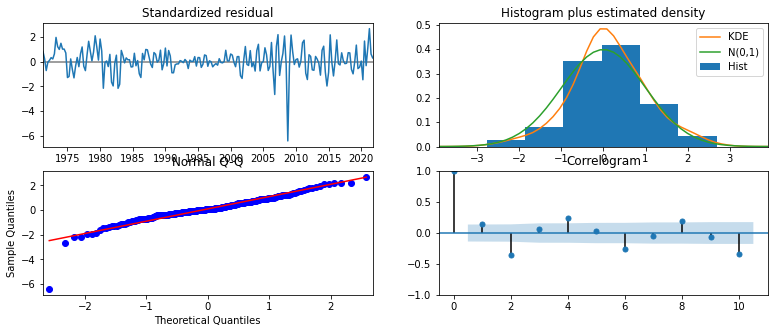

In [47]:
inf_results.plot_diagnostics(figsize=(13, 5));

We can also produce in-sample one-step-ahead predictions and out-of-sample forecasts:

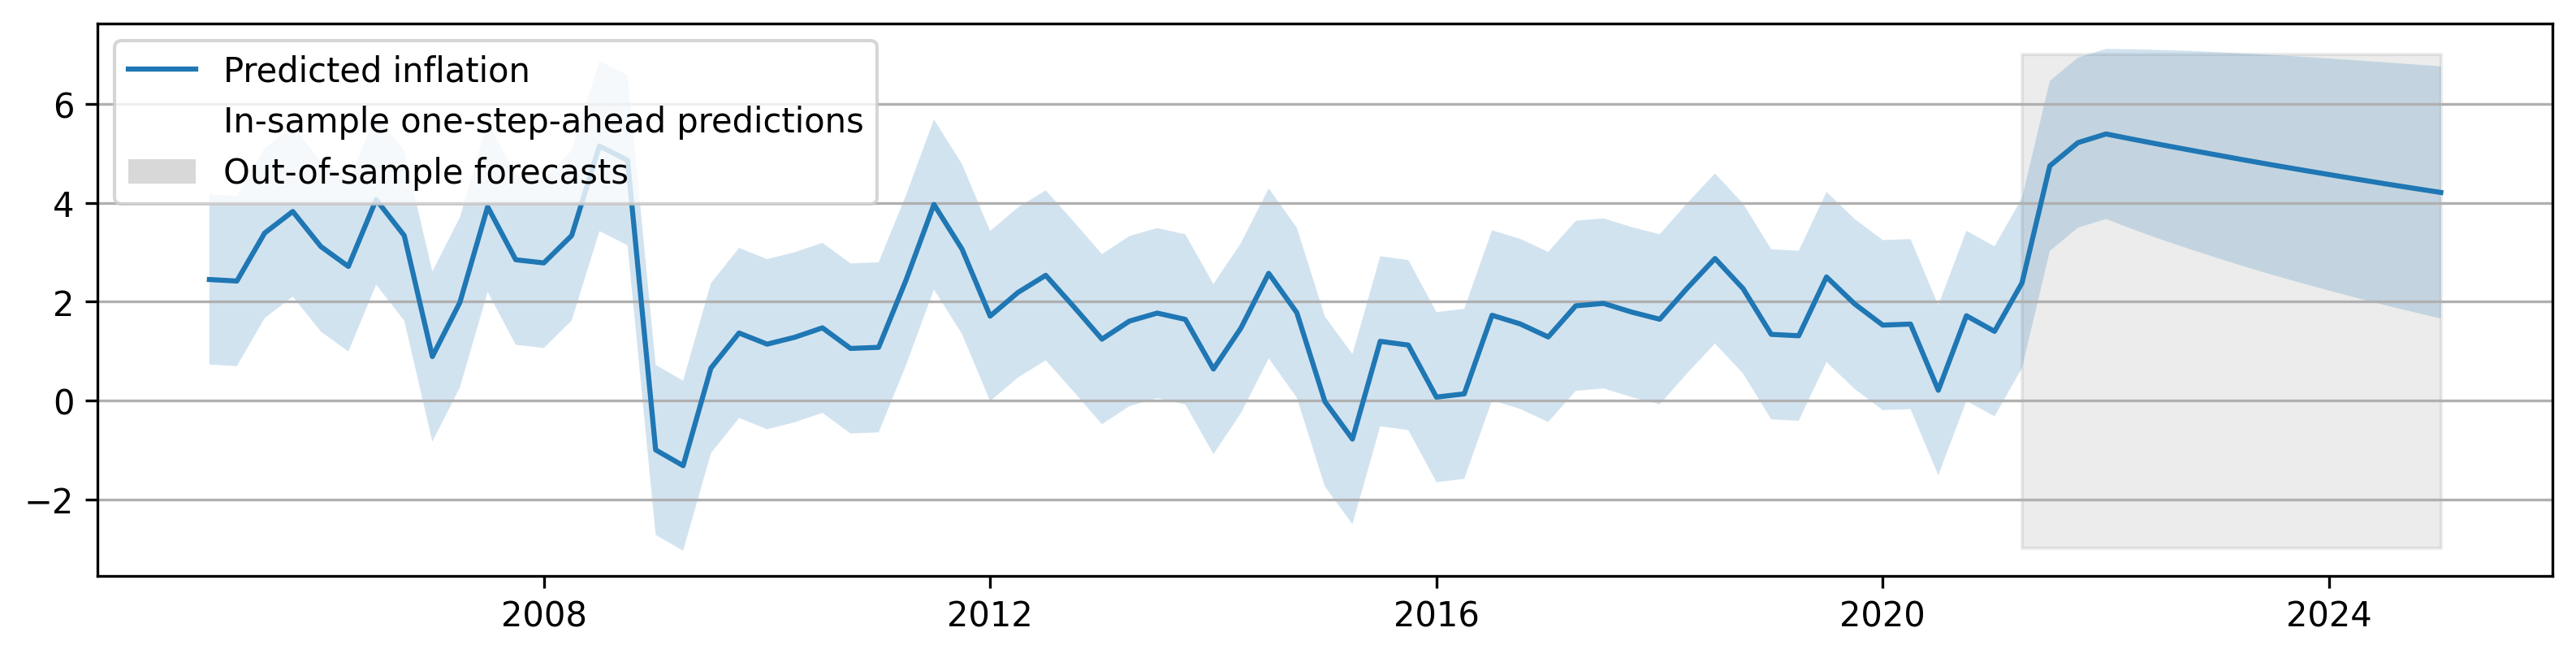

In [48]:
# Construct the predictions / forecasts
inf_forecast = inf_results.get_prediction(start='2005-01-01', end='2025-01-01')

# Plot them
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

forecast = inf_forecast.predicted_mean
ci = inf_forecast.conf_int(alpha=0.5)

#ax.fill_between(forecast.ix['2017-01-02':].index, -3, 7, color='grey',alpha=0.15)
ax.fill_between(forecast['2021-01-02':].index, -3, 7, color='grey',alpha=0.15)
lines, = ax.plot(forecast.index, forecast)
ax.fill_between(forecast.index, ci['lower CPIAUCNS'], ci['upper CPIAUCNS'],
                alpha=0.2)

p1 = plt.Rectangle((0, 0), 1, 1, fc="white")
p2 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)
ax.legend([lines, p1, p2], ["Predicted inflation",
                            "In-sample one-step-ahead predictions",
                            "Out-of-sample forecasts"], loc='upper left')
ax.yaxis.grid()

And we can produce impulse responses.

In [49]:
# Construct the impulse responses
inf_irfs = inf_results.impulse_responses(steps=10)

print(inf_irfs)

0     1.000000
1     0.352159
2     0.344962
3     0.337912
4     0.331006
5     0.324241
6     0.317614
7     0.311123
8     0.304764
9     0.298536
10    0.292435
Name: CPIAUCNS, dtype: float64


## ARMA(1, 1) in Statsmodels via SARIMAX

The large class of seasonal autoregressive integrated moving average models - SARIMAX(p, d, q)x(P, D, Q, S) - is implemented in Statsmodels in the `sm.tsa.SARIMAX` class.

First, we'll check that fitting an ARMA(1, 1) model by maximum likelihood using `sm.tsa.SARIMAX` gives the same results as our `ARMA11` class, above.

In [50]:
inf_model2 = sm.tsa.SARIMAX(inf, order=(1, 0, 1))
inf_results2 = inf_model2.fit()

print(inf_results2.summary())

                           Statespace Model Results                           
Dep. Variable:               CPIAUCNS   No. Observations:                  203
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -479.181
Date:                Sat, 14 May 2022   AIC                            964.361
Time:                        16:08:56   BIC                            974.301
Sample:                    04-01-1971   HQIC                           968.382
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9796      0.015     63.260      0.000       0.949       1.010
ma.L1         -0.6274      0.058    -10.907      0.000      -0.740      -0.515
sigma2         6.5159      0.329     19.786      0.0

## Metropolis-Hastings - ARMA(1, 1)

Here we show how to estimate the ARMA(1, 1) model via Metropolis-Hastings using PyMC. Recall that the ARMA(1, 1) model has three parameters: $(\phi, \theta, \sigma^2)$.

For $\phi$ and $\theta$ we specify uniform priors of $(-1, 1)$, and for $1 / \sigma^2$ we specify a $\Gamma(2, 4)$ prior.

In [51]:
!pip install pymc

In [52]:
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = sm.tsa.SARIMAX(inf, order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=sm.tsa.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1 / precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=10000, burn=1000, thin=10)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 10000 of 10000 complete in 38.0 sec

Plotting theta
Plotting precision
Plotting phi


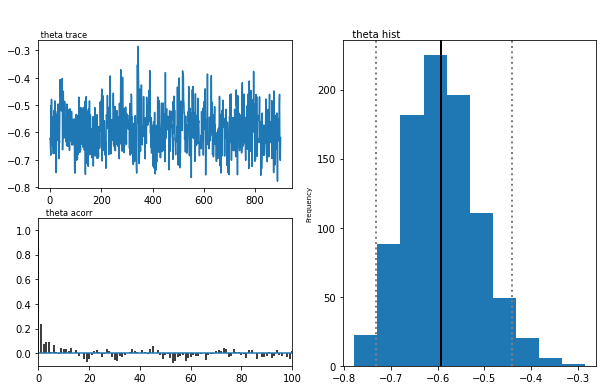

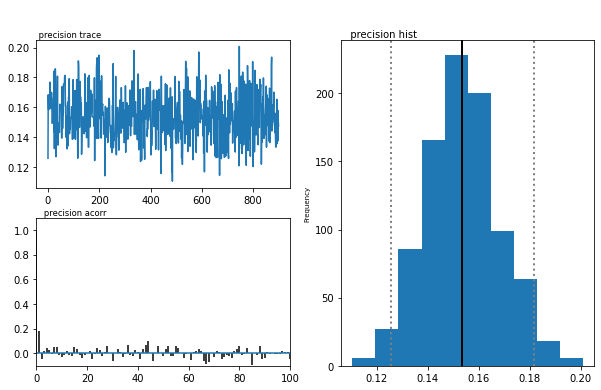

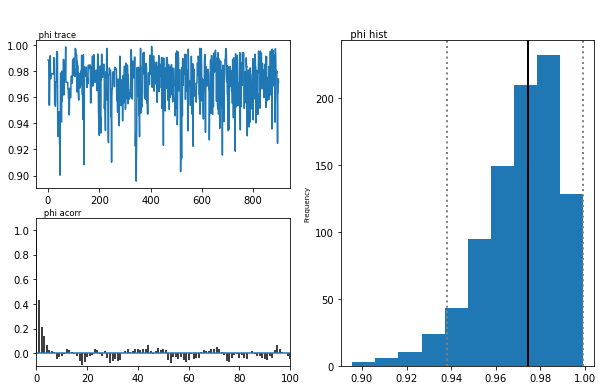

In [53]:
# Plot traces
mc.Matplot.plot(sampler)

## Gibbs Sampling - ARMA(1, 1)

Here we show how to estimate the ARMA(1, 1) model via Metropolis-within-Gibbs Sampling.

In [ ]:
from scipy.stats import multivariate_normal, invgamma

def draw_posterior_phi(model, states, sigma2):
    Z = states[0:1, 1:]
    X = states[0:1, :-1]

    tmp = np.linalg.inv(sigma2 * np.eye(1) + np.dot(X, X.T))
    post_mean = np.dot(tmp, np.dot(X, Z.T))
    post_var = tmp * sigma2

    return multivariate_normal(post_mean, post_var).rvs()

def draw_posterior_sigma2(model, states, phi):
    resid = states[0, 1:] - phi * states[0, :-1]
    post_shape = 3 + model.nobs
    post_scale = 3 + np.sum(resid**2)

    return invgamma(post_shape, scale=post_scale).rvs()

np.random.seed(17429)

from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible

# Create the model for likelihood evaluation and the simulation smoother
model = ARMA11(inf)
sim_smoother = model.simulation_smoother()

# Create the random walk and comparison random variables
rw_proposal = norm(scale=0.3)

# Create storage arrays for the traces
n_iterations = 10000
trace = np.zeros((n_iterations + 1, 3))
trace_accepts = np.zeros(n_iterations)
trace[0] = [0, 0, 1.]  # Initial values

# Iterations
for s in range(1, n_iterations + 1):
    # 1. Gibbs step: draw the states using the simulation smoother
    model.update(trace[s-1], transformed=True)
    sim_smoother.simulate()
    states = sim_smoother.simulated_state[:, :-1]

    # 2. Gibbs step: draw the autoregressive parameters, and apply
    # rejection sampling to ensure an invertible lag polynomial
    phi = draw_posterior_phi(model, states, trace[s-1, 2])
    while not is_invertible([1, -phi]):
        phi = draw_posterior_phi(model, states, trace[s-1, 2])
    trace[s, 0] = phi

    # 3. Gibbs step: draw the variance parameter
    sigma2 = draw_posterior_sigma2(model, states, phi)
    trace[s, 2] = sigma2

    # 4. Metropolis-step for the moving-average parameter
    theta = trace[s-1, 1]
    proposal = theta + rw_proposal.rvs()
    if proposal > -1 and proposal < 1:
        acceptance_probability = np.exp(
            model.loglike([phi, proposal, sigma2]) -
            model.loglike([phi, theta, sigma2]))

        if acceptance_probability > uniform.rvs():
            theta = proposal
            trace_accepts[s-1] = 1
    trace[s, 1] = theta
    
# For analysis, burn the first 1000 observations, and only
# take every tenth remaining observation
burn = 1000
thin = 10
final_trace = trace[burn:][::thin]

In [ ]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(2, 2, figsize=(13, 5), dpi=300)

phi_kde = gaussian_kde(final_trace[:, 0])
theta_kde = gaussian_kde(final_trace[:, 1])
sigma2_kde = gaussian_kde(final_trace[:, 2])

#axes[0, 0].hist(final_trace[:, 0], bins=20, normed=True, alpha=1)
axes[0, 0].hist(final_trace[:, 0], bins=20, density=True, alpha=1)
X = np.linspace(0.75, 1.0, 5000)
line, = axes[0, 0].plot(X, phi_kde(X))
ylim = axes[0, 0].get_ylim()
vline = axes[0, 0].vlines(final_trace[:, 0].mean(), ylim[0], ylim[1],
                          linewidth=2)
axes[0, 0].set(title=r'$\phi$')

#axes[0, 1].hist(final_trace[:, 1], bins=20, normed=True, alpha=1)
axes[0, 1].hist(final_trace[:, 1], bins=20, density=True, alpha=1)
X = np.linspace(-0.9, 0.0, 5000)
axes[0, 1].plot(X, theta_kde(X))
ylim = axes[0, 1].get_ylim()
vline = axes[0, 1].vlines(final_trace[:, 1].mean(), ylim[0], ylim[1],
                          linewidth=2)
axes[0, 1].set(title=r'$\theta$')

#axes[1, 0].hist(final_trace[:, 2], bins=20, normed=True, alpha=1)
axes[1, 0].hist(final_trace[:, 2], bins=20, density=True, alpha=1)
X = np.linspace(4, 8.5, 5000)
axes[1, 0].plot(X, sigma2_kde(X))
ylim = axes[1, 0].get_ylim()
vline = axes[1, 0].vlines(final_trace[:, 2].mean(), ylim[0], ylim[1],
                          linewidth=2)
axes[1, 0].set(title=r'$\sigma^2$')

p1 = plt.Rectangle((0, 0), 1, 1, alpha=0.7)
axes[0, 0].legend([p1, line, vline],
                  ["Histogram", "Gaussian KDE", "Sample mean"],
                  loc='upper left')

axes[1, 1].plot(final_trace[:, 0], label=r'$\phi$')
axes[1, 1].plot(final_trace[:, 1], label=r'$\theta$')
axes[1, 1].plot(final_trace[:, 2], label=r'$\sigma^2$')
axes[1, 1].legend(loc='upper left')
axes[1, 1].set(title=r'Trace plots')
fig.tight_layout()

## Expanded model: SARIMAX

We'll try a more complicated model now: SARIMA(3, 0, 0)x(0, 1, 1, 4). The ability to include a seasonal effect is important, since the data series we selected is not seasonally adjusted.

We also add an explanatory "impulse" variable to account for the clear outlier in the fourth quarter of 2008. We'll estimate this model by maximum likelihood.

In [ ]:
outlier_exog = pd.Series(np.zeros(len(inf)), index=inf.index, name='outlier')
outlier_exog['2008-10-01'] = 1
inf_model3 = sm.tsa.SARIMAX(inf, order=(3, 0, 0), seasonal_order=(0, 1, 1, 4), exog=outlier_exog)
inf_results3 = inf_model3.fit()

print(inf_results3.summary())

In [ ]:
inf_results3.plot_diagnostics(figsize=(13, 5));

In terms of the reported model diagnostics, this model appears to do a better job of explaining the inflation series - although it is far from perfect.

In [ ]:
# Construct the predictions / forecasts
# Notice that now to forecast we need to provide an expanded
# outlier_exog series for the new observations
outlier_exog_fcast = np.zeros((13,1))
inf_forecast3 = inf_results3.get_prediction(
    start='2005-01-01', end='2025-01-01', exog=outlier_exog_fcast)

# Plot them
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

forecast = inf_forecast3.predicted_mean
ci = inf_forecast3.conf_int(alpha=0.5)

ax.fill_between(forecast['2021-01-02':].index, -10, 7, color='grey',
                alpha=0.15)
lines, = ax.plot(forecast.index, forecast)
ax.fill_between(forecast.index, ci['lower CPIAUCNS'], ci['upper CPIAUCNS'],
                alpha=0.2)

p1 = plt.Rectangle((0, 0), 1, 1, fc="white")
p2 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)
ax.legend([lines, p1, p2], ["Predicted inflation",
                            "In-sample one-step-ahead predictions",
                            "Out-of-sample forecasts"], loc='lower left')
ax.yaxis.grid()